In [564]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cmath

from datetime import datetime, date

from sktensor import dtensor, cp_als
# matplotlib.style.use('ggplot')


from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import precision_recall_curve, average_precision_score
from sktensor import dtensor, cp_als

matplotlib.style.use('ggplot')

In [565]:
# Downloading and preprocessing the dataset
# The variable "tab" has integers datetime
execfile('Library/Initialization_rado-square_matrix.py')
T.shape

(167, 167, 238)

In [487]:
#date = pd.to_datetime('2010-01-19')
#date.toordinal()

In [488]:
#dipou_brthd = 733791

In [489]:
#row_list = tab.datetime == dipou_brthd
#edge_list = zip(tab.sender[row_list], tab.receiver[row_list])

#G=nx.Graph()
#G.add_edges_from(edge_list)

In [490]:
#print '%d mails exchanged between %d employees the %s' %(nx.number_of_edges(G), 
#                                                         nx.number_of_nodes(G), 
#                                                         str(date))

In [491]:
#nx.draw(G)

### Dataset Temporal Split
We use (sender,receiver)_t matrix for t between t_0 and t_1. This temporal window shifts as t_0 incresases.  
t_0 is s.t. t_0+t_1 <= T.shape[2] = 238  
  
Since we would like to move this window around 3 weeks, we choose t_0 <= 21 and a constant window size of length 238-21=217

In [566]:
t_0 = 7
t_1 = t_0 + 217

if t_1 <= T.shape[2]:
    T_train = T[:, :, t_0:t_1]
    T_test = T[:, :, t_1:]
    print('Initial time: t_0 = %d [%s / %d]\nFinal time:   t_1 = %d [%s / %d]') %(t_0,
                                                                                  date.fromordinal(k_list[t_0]),
                                                                                  k_list[t_0],
                                                                                  t_1,
                                                                                  date.fromordinal(k_list[t_1]),
                                                                                  k_list[t_1])
else:
    print('t_0=%d is superior to the maximal value 21!') %(t_0)

Initial time: t_0 = 7 [2010-01-10 / 733782]
Final time:   t_1 = 224 [2010-09-16 / 734031]


In [567]:
#Proportion of non-zero entries of the tensor
mail_rate = np.count_nonzero(T) / float(T.shape[0] * T.shape[1] * T.shape[2])

In [568]:
# Collapsed weighted tensor
CT = np.zeros((T[:,:,0].shape[0], T[:,:,0].shape[1]))
theta = 0.2
K = len(k_list)

for k in range(K):
    CT = CT + (1-theta)**(K - k)*T[:,:,k]

In [569]:
CT

dtensor([[ 0.        ,  0.69987861,  0.79923661, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69598695,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79389821,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### TSVD

In [570]:
type(T[:,:,0])
T.shape

(167, 167, 238)

In [571]:
T.shape[2]

238

In [572]:
U, Sigma, Vt = randomized_svd(CT, n_components=15, n_iter=5, random_state=None)

In [573]:
#print(svd.explained_variance_ratio_)
#print(svd.explained_variance_ratio_.sum()) 

In [574]:
U.shape

(167, 15)

In [557]:
Vt.shape

(15, 167)

In [558]:
len(Sigma)

15

In [559]:
TSVDScore = np.dot(np.dot(U,np.diag(Sigma)),Vt)

In [560]:
TSVDScore

array([[ 0.35199928, -0.03317182,  0.83106529, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82535057,  1.68688599, -0.23431441, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.88569104,  0.05916778, -0.05382976, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [561]:
S = TSVDScore

In [575]:
#Converting S into S_pred, a binary matrix
thres = 1  # If the score above thres, we predict an email

S_pred = (1*(S >= thres))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

### Precision-Recall for several values of K

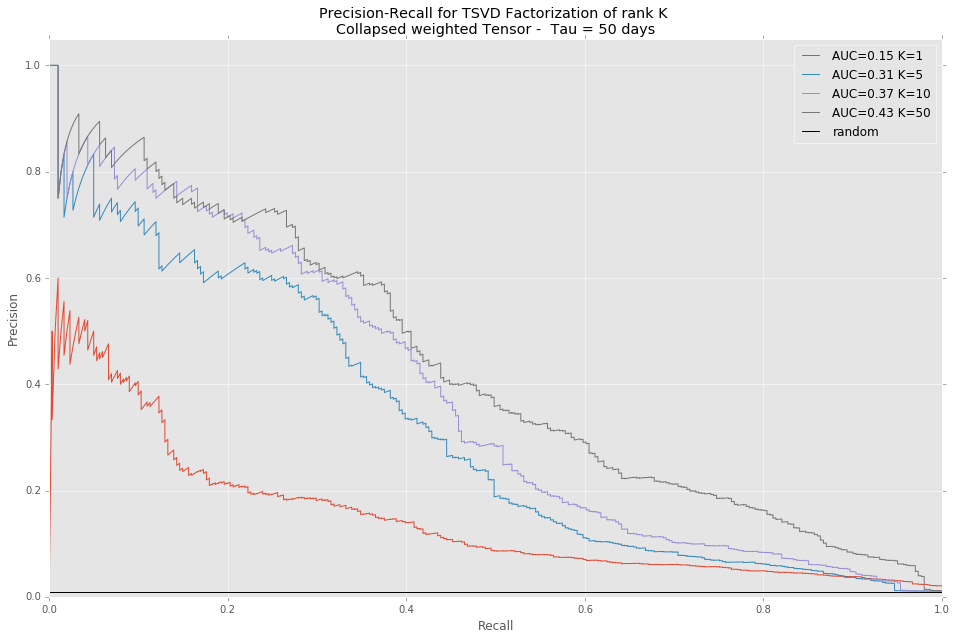

In [583]:
K_list = [1, 5, 10, 50]
tau_list = [1, 7, 50]
theta = 0.2
k_ = len(k_list)

for tau_ind in range(len(tau_list)):
    # Choice of tau
    tau = tau_list[tau_ind]
    # Initialization
    precision = dict()
    recall = dict()
    average_precision = dict()
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # TSVD Decomposition
        U, Sigma, Vt = randomized_svd(CT, n_components=K, n_iter=5, random_state=None)
        # TSVD Scoring
        S = np.dot(np.dot(U,np.diag(Sigma)),Vt)
        y_score = S.flatten()
        y_test = S_test.flatten()    
        # Precision-Recall
        precision[K_ind], recall[K_ind], _ = precision_recall_curve(y_test,
                                                            y_score)
        average_precision[K_ind] = average_precision_score(y_test, y_score)    

    # Plotting the results
    plt.clf()
    plt.figure(figsize=(16, 10))

    for K_ind in range(len(K_list)):
        plt.plot(recall[K_ind], precision[K_ind], label='AUC={0:0.2f} K=%d' .format(average_precision[K_ind]) %K_list[K_ind])

    plt.axhline(mail_rate, label='random', color='black')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="upper right")
    plt.title('Precision-Recall for TSVD Factorization of rank K \nCollapsed weighted Tensor -  Tau = %d days' %(tau))
    plt.savefig('cp_roc_cut_%d.png' %(tau))    

### Katz score

In [613]:
beta = 0.001

In [614]:
CT.shape

(167, 167)

In [615]:
KatzScore = np.linalg.inv((np.eye(Adj_matrix.shape[0]) - beta*Adj_matrix)) - np.eye(Adj_matrix.shape[0])

In [616]:
KatzScore

matrix([[  1.36028047e-04,   1.06687099e-03,   1.06375812e-03, ...,
           1.08464574e-06,   2.09289296e-06,   1.06295233e-06],
        [  1.06687099e-03,   6.73846663e-05,   3.62260258e-05, ...,
           1.04888209e-06,   1.00008548e-03,   1.04243202e-06],
        [  1.06375812e-03,   3.62260258e-05,   6.33193783e-05, ...,
           1.05282283e-06,   1.05839331e-06,   1.04641817e-06],
        ..., 
        [  1.08464574e-06,   1.04888209e-06,   1.05282283e-06, ...,
           1.00008547e-06,   2.07130129e-09,   1.05297417e-09],
        [  2.09289296e-06,   1.00008548e-03,   1.05839331e-06, ...,
           2.07130129e-09,   2.00013009e-06,   1.06255975e-09],
        [  1.06295233e-06,   1.04243202e-06,   1.04641817e-06, ...,
           1.05297417e-09,   1.06255975e-09,   1.00006652e-06]])

In [617]:
KatzScore.shape

(166, 166)

In [618]:
KatzScore.min()

6.2668668773303596e-15

In [619]:
KatzScore.max()

0.0011410867282873802

In [620]:
#Converting S into S_pred, a binary matrix
thres = 1  # If the score above thres, we predict an email

S_pred = (1*(S >= thres))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

### Precision-Recall for several values of K

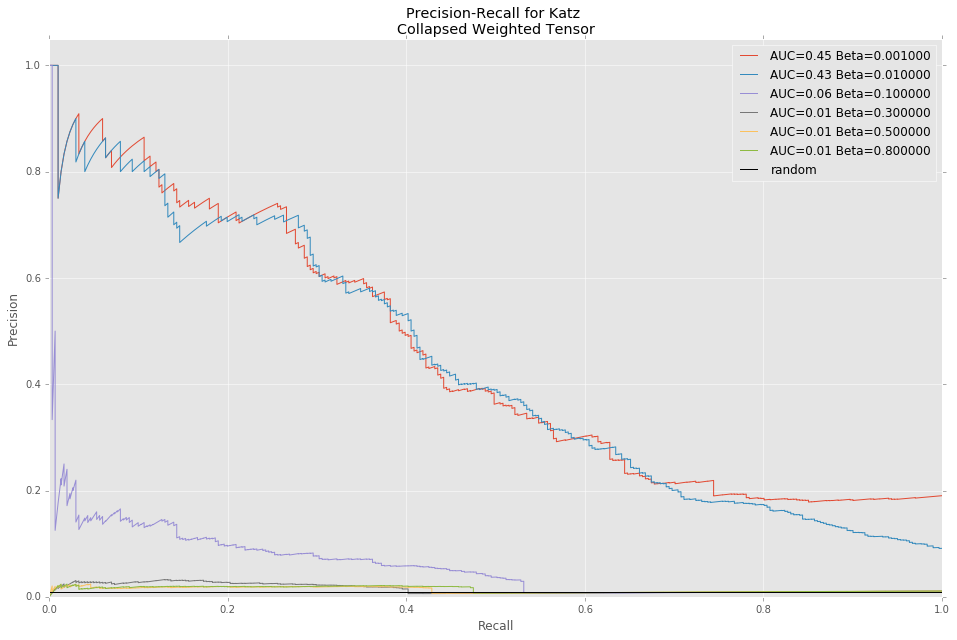

In [622]:
beta_list = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8]
precision = dict()
recall = dict()
average_precision = dict()

for beta in beta_list :
    # Katz Scoring
    S = np.linalg.inv((np.eye(CT.shape[0]) - beta*CT)) - np.eye(CT.shape[0])
    y_score = S.flatten()
    y_test = S_test.flatten()    
    # Precision-Recall
    precision[beta], recall[beta], _ = precision_recall_curve(y_test,
                                                        y_score)
    average_precision[beta] = average_precision_score(y_test, y_score)    

    # Plotting the results
    plt.clf()
    plt.figure(figsize=(16, 10))
    
for beta in beta_list :
    plt.plot(recall[beta], precision[beta], label='AUC={0:0.2f} Beta=%f' .format(average_precision[beta]) %(beta))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Precision-Recall for Katz \nCollapsed Weighted Tensor')
plt.savefig('cp_roc_cut_%d.png' %(tau))     

In [612]:
beta = 0.5
S = np.linalg.inv((np.eye(CT.shape[0]) - beta*CT)) - np.eye(CT.shape[0])
S.shape

(167, 167)

### TKatz

In [533]:
# Rank of the adjacency matrix
np.linalg.matrix_rank(CT)

0

In [534]:
# Eigendecomposition
D, W = np.linalg.eig(Adj_matrix)

In [535]:
print W.shape, D.shape

(166, 166) (166,)


In [536]:
# Check orthogonality
P = np.dot(np.linalg.inv(W),W)
np.allclose(P, np.eye(len(P)))

True

In [416]:
# Only real numbers
count = 0
for i in D :
    if i.imag == 0 :
        count += 1

count

164

In [405]:
count = 0
for i in range(1,len(D)) :
    if abs(D[i-1]) >= abs(D[i]) :
        count += 1

print count

128


In [438]:
for value in range(len(D)) :
    D[value] = D[value].real

In [463]:
alpha = []
for i in D :
    alpha += [1./(1-i)] 

In [464]:
TKatzScore = np.dot(W,np.dot(np.diag(alpha),W.transpose()))

In [432]:
for value in range(len(TKatzScore)) :
    TKatzScore[value] = TKatzScore[value].real

In [429]:
# Only real numbers
count = 0
for i in range(TKatzScore.shape[0]) :
    for j in range(TKatzScore.shape[1]) :
        if TKatzScore[i,j].imag == 0 :
            count += 1

count

27556

In [430]:
TKatzScore.shape[0]*TKatzScore.shape[1]

27556

In [465]:
TKatzScore.min()

(-6.5924192010954634+0j)

In [466]:
TKatzScore.max()

(15.723552084502224+0j)

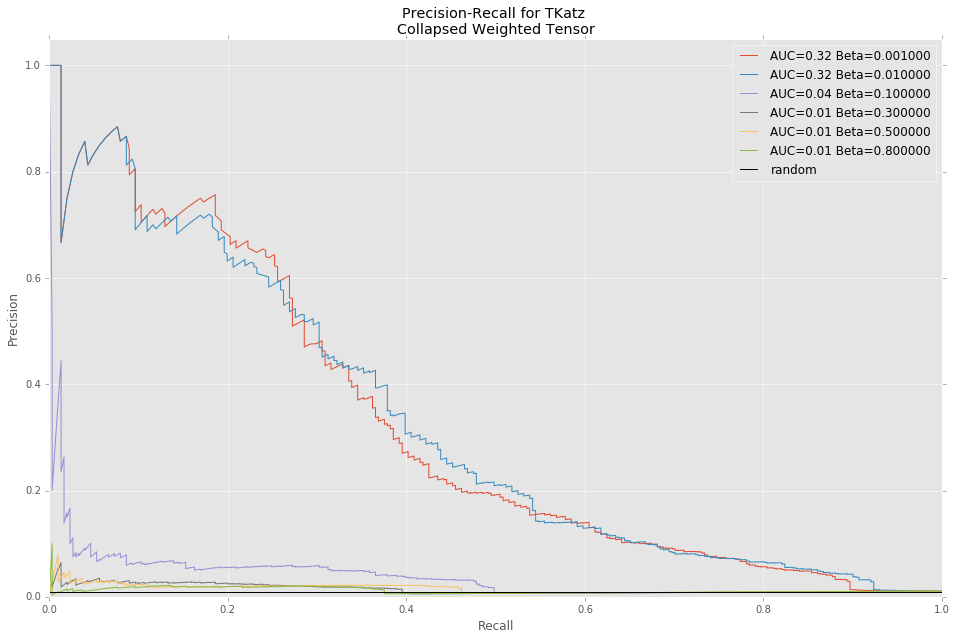

In [625]:
beta_list = [0.001, 0.01, 0.1, 0.3, 0.5, 0.8]
precision = dict()
recall = dict()
average_precision = dict()

for beta in beta_list :
    alpha = []
    for i in D :
        alpha += [1./(1-beta*i) - 1] 
    # TKatz Scoring
    S = np.dot(W,np.dot(np.diag(alpha),W.transpose()))
    y_score = S.flatten()
    y_test = S_test.flatten()    
    # Precision-Recall
    precision[beta], recall[beta], _ = precision_recall_curve(y_test,
                                                        y_score)
    average_precision[beta] = average_precision_score(y_test, y_score)    

    # Plotting the results
    plt.clf()
    plt.figure(figsize=(16, 10))
    
for beta in beta_list :
    plt.plot(recall[beta], precision[beta], label='AUC={0:0.2f} Beta=%f' .format(average_precision[beta]) %(beta))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Precision-Recall for TKatz \nCollapsed Weighted Tensor')
plt.savefig('cp_roc_cut_%d.png' %(tau))     